# Benchmarks - Prediction

**Main considerations when implementing Magma's Prediction*

* Opposite to MagmaClustR, we want to be able to perform multiple predictions in one go, in parallel.


---
## Setup

In [1]:
# Standard library
import os

from MagmaClustPy.hyperpost import hyperpost

os.environ['JAX_ENABLE_X64'] = "True"

In [2]:
# Third party
import jax.numpy as jnp

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
# Local
from MagmaClustPy.kernels import SEMagmaKernel
from MagmaClustPy.utils import preprocess_db

In [4]:
# Config

---
## Data

In [5]:
# Dummy data to test
db = pd.DataFrame({
	'ID': [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3],
	'Input': [0.40, 4.45, 7.60, 8.30, 3.50, 5.10, 8.85, 9.35, 0.55, 2.60, 4.20, 5.75, 6.15, 7.10, 9.50],
	'Output': [59.81620, 67.13694, 78.32495, 81.83590, 62.04943, 67.31932, 85.94063, 86.76426, 60.46263, 64.92184,
	           68.48024, 72.56274, 76.07257, 80.58012, 84.52813]
})

In [6]:
db[db['ID'] < 3]

,ID,Input,Output
0,1,0.40,59.81620
1,1,4.45,67.13694
2,1,7.60,78.32495
3,1,8.30,81.83590
4,2,3.50,62.04943
5,2,5.10,67.31932
6,2,8.85,85.94063
7,2,9.35,86.76426


In [7]:
all_inputs_train, padded_inputs_train, padded_outputs_train, masks_train = preprocess_db(db[db['ID'] < 3])
all_inputs_train.shape, padded_inputs_train.shape

((8,), (2, 8))

In [9]:
all_inputs_test, padded_inputs_test, padded_outputs_test, masks_test = preprocess_db(db[db['ID'] >= 3])
all_inputs_test.shape, padded_inputs_test.shape

((7,), (1, 7))

---
## Current implementation

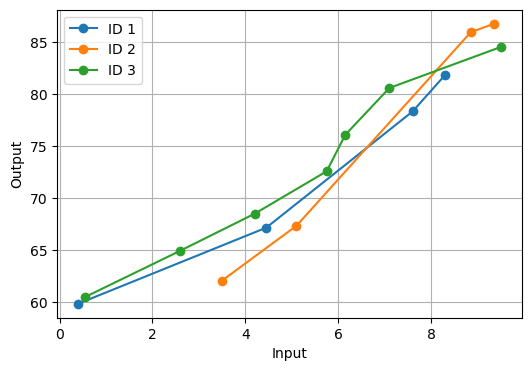

In [10]:
# plot the profiles
# Plot
plt.figure(figsize=(6, 4))
for id_, group in db.groupby('ID'):
	plt.plot(group['Input'], group['Output'], marker='o', label=f'ID {id_}')

# Labels and legend
plt.xlabel("Input")
plt.ylabel("Output")
plt.legend()
plt.grid()
plt.show()

In [11]:
mean_kern = SEMagmaKernel(length_scale=2.913873, variance=7.766141)  # Optimal value from MagmaClustR
task_kern = SEMagmaKernel(length_scale=1.787864, variance=1.455233)  # Optimal value from MagmaClustR

In [23]:
post_mean, post_cov = hyperpost(padded_inputs_train, padded_outputs_train, masks_train, jnp.array(0), mean_kern,
                                task_kern, all_inputs=all_inputs_train)

In [24]:
np.asarray(post_cov)

array([[3.9238002 , 0.68786734, 0.4913745 , 0.40921137, 0.07746234,
        0.03670207, 0.04061443, 0.06944349],
       [0.68786895, 2.3367457 , 1.9917192 , 1.685007  , 0.5545117 ,
        0.32141554, 0.18794648, 0.11629809],
       [0.49137712, 1.9917206 , 2.1368644 , 2.059674  , 0.9459238 ,
        0.627762  , 0.42646176, 0.28542706],
       [0.40921298, 1.6850079 , 2.0596733 , 2.1495214 , 1.2916361 ,
        0.92802155, 0.6814257 , 0.5043015 ],
       [0.07746391, 0.55451345, 0.9459252 , 1.2916368 , 2.1565828 ,
        2.0575771 , 1.8877145 , 1.6967535 ],
       [0.03670055, 0.32141894, 0.627764  , 0.9280222 , 2.0575774 ,
        2.136539  , 2.0875633 , 1.9665248 ],
       [0.04061404, 0.18794757, 0.4264613 , 0.6814245 , 1.8877149 ,
        2.0875635 , 2.1524358 , 2.1311905 ],
       [0.06944409, 0.11630308, 0.28542963, 0.5043027 , 1.6967541 ,
        1.9665252 , 2.1311905 , 2.2423105 ]], dtype=float32)

In [25]:
np.asarray(post_mean)

array([58.767086, 63.865337, 66.04876 , 68.028786, 79.690475, 83.03334 ,
       85.01304 , 86.02761 ], dtype=float32)

In [26]:
magma_post_mean = jnp.array([58.51787, 63.68543, 65.88563, 67.87112, 79.42533, 82.75855, 84.77454, 85.86286])
magma_post_cov = jnp.array([[4.76069, 1.08064, 0.861161, 0.742202, 0.117828, 0.0230036, 0.0135281, 0.0514975],
                            [1.08064, 2.91396, 2.52377, 2.18310, 0.927228, 0.631739, 0.430066, 0.282036],
                            [0.861161, 2.52377, 2.68749, 2.60878, 1.38338, 1.00744, 0.754443, 0.562014],
                            [0.742202, 2.18310, 2.60878, 2.72367, 1.78506, 1.35312, 1.04982, 0.823564],
                            [0.117828, 0.927228, 1.38338, 1.78506, 2.79972, 2.64583, 2.38762, 2.08305],
                            [0.0230036, 0.631739, 1.00744, 1.35312, 2.64583, 2.72265, 2.63719, 2.44841],
                            [0.0135281, 0.430066, 0.754443, 1.04982, 2.38762, 2.63719, 2.73519, 2.73480],
                            [0.0514975, 0.282036, 0.562014, 0.823564, 2.08305, 2.44841, 2.73480, 2.99548]])

---
## Custom implementation(s)

---
## Comparison

---
## Conclusion

---